# Spatio-Temporal Variogram (Daily)

### Clean the data

First, load library and set encoding

In [1]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



[1] "Thai_Thailand.874"

Set working directory (if needed)

In [2]:
#setwd("C:\\Users\\garavig\\Documents\\Haze\\HazeAnalysis\\Data")

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [3]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load hourly data

In [4]:
#hour<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/H_Mar_PM25_2561.csv")
daily<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/PM2-5_2018_Daily.csv")

In [5]:
#head(hour)
colnames(daily)<-c('sensorid','date','pm25')
head(daily)

sensorid,date,pm25
CU-S0001,28-02-2018,52.52500
CU-S0002,15-02-2018,62.89826
CU-S0002,16-02-2018,50.96376
CU-S0002,17-02-2018,77.15833
CU-S0002,18-02-2018,79.91827
CU-S0002,19-02-2018,72.95452


In [6]:
#hour[hour$sensorid=="CU-SOO94",1]<-"CU-S0094"
daily[daily$sensorid=="CU-SOO94",1]<-"CU-S0094"

In [7]:
sqldf("select sensorid,count(pm25),min(date),max(date) from daily group by sensorid")

sensorid,count(pm25),min(date),max(date)
CU-S0001,1,28-02-2018,28-02-2018
CU-S0002,97,01-03-2018,31-05-2018
CU-S0003,108,01-03-2018,31-05-2018
CU-S0004,87,01-03-2018,31-03-2018
CU-S0005,99,01-03-2018,31-05-2018
CU-S0006,102,01-03-2018,31-05-2018
CU-S0007,1,28-02-2018,28-02-2018
CU-S0008,106,01-03-2018,31-05-2018
CU-S0009,54,01-06-2018,31-05-2018
CU-S0010,84,01-03-2018,31-05-2018


Update time to POSIXct

In [8]:
#hour$timepos <- as.POSIXct(strptime(paste(hour$date,hour$h), "%Y-%m-%d %H"))
daily$timepos <- as.POSIXct(strptime(daily$date, "%d-%m-%Y"))

## Deal with missing values

Create date sequence from start to end.

In [9]:
#date_seq<-seq(min(daily$timepos), max(daily$timepos), "days")

Then,create repete sensorid

In [10]:
#sen_uni<-sqldf("select distinct(sensorid) from daily")
#sen_rep<-rep()

In [11]:
#pm25Data <- mice(daily,m=5,maxit=50,meth='pmm',seed=500)
#summary(pm25Data)

ERROR: Error in eval(expr, envir, enclos): could not find function "mice"


Select only one day, then order it by timepos and sensorid respectively.

In [12]:
#newhour<-hour[hour$timepos>="2018-03-08 00:00:00" & hour$timepos<="2018-03-08 23:00:00",]
#newhour <- newhour[order(newhour$sensorid, newhour$timepos),]
newdaily<-daily[daily$timepos>="2018-03-01" & daily$timepos<="2018-03-31",]
newdaily<- newdaily[order(newdaily$timepos, newdaily$sensorid),]

Count number of rows per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor มีครบ 24 ชั่วโมงหรือไม่

In [13]:
#count<-sqldf("select sensorid,count() from newhour group by sensorid") 
count<-sqldf("select sensorid,count() from newdaily group by sensorid") 
colnames(count)<-c("sensorid","c")
#sensorFull <-as.matrix(count[count$c == 24,]$sensorid)
sensorFull <-as.matrix(count[count$c == 31,]$sensorid)
sensorFull

CU-S0004
CU-S0011
CU-S0014
CU-S0022
CU-S0024
CU-S0029
CU-S0030
CU-S0032
CU-S0035
CU-S0039
CU-S0042


Select only sensors that has 24 hour data

In [14]:
#newhour<-subset(newhour,sensorid %in% sensorFull)
newdaily<-subset(newdaily,sensorid %in% sensorFull)
#sqldf("select sensorid,min(date),max(date) from newdaily group by sensorid")

Check whether there is a weird value in the data.

In [15]:
#sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newhour group by sensorid")
sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newdaily group by sensorid order by max(pm25) desc")

sensorid,min(pm25),max(pm25),avg(pm25)
CU-S0059,29.553295,171.63920,94.61422
CU-S0050,32.052113,154.17626,97.54773
CU-S0032,31.415857,151.13732,93.71037
CU-S0082,30.614242,147.61969,91.59067
CU-S0046,25.849739,146.64490,75.52957
CU-S0076,29.840341,146.43197,86.00739
CU-S0051,34.120061,144.64447,89.43083
CU-S0098,30.402699,142.41799,88.59156
CU-S0030,31.475393,142.14235,90.66519
CU-S0035,25.547982,137.17351,76.74935


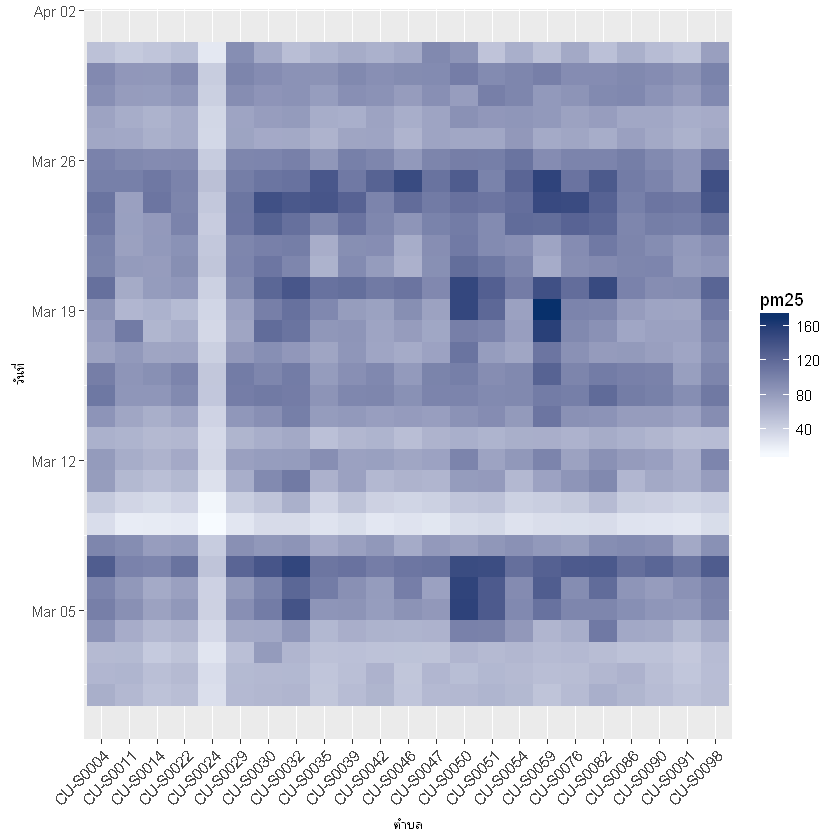

In [16]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")
ggplot(newdaily, aes(y=timepos,x=sensorid)) +geom_tile(aes(fill = pm25))+ scale_fill_gradient(low=colorsetting[1],high=colorsetting[9])+labs(y = "วันที่",x="ตำบล")+theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Input into the model

The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [17]:
#datetime<-sqldf('select distinct(timepos) from newhour') #USE THIS
datetime<-sqldf('select distinct(timepos) from newdaily')
datetime<-as.data.frame(datetime[order(datetime$timepos),])
colnames(datetime)<-c("timepos")
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- as.data.frame(sensorid[order(sensorid$sensorid),])
row.names(sensorid) = sensorid$sensorid

In [18]:
#write.csv(sensorid,file="sensorid.csv")
#write.csv(newdaily,file="newhour.csv")

Create a SpatialPointsDataFrame

In [19]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [20]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

Project lat/lon to UTM Zone 47

In [21]:
library(rgdal)
sensoridSP.UTM <- spTransform(sensoridSP, CRS("+init=epsg:32647"))

rgdal: version: 1.2-16, (SVN revision 701)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.2.0, released 2017/04/28
 Path to GDAL shared files: C:/Users/garavig/Documents/R/win-library/3.3/rgdal/gdal
 GDAL binary built with GEOS: TRUE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 shared files: C:/Users/garavig/Documents/R/win-library/3.3/rgdal/proj
 Linking to sp version: 1.2-7 


Warning message in title(...):
""zcol" is not a graphical parameter"

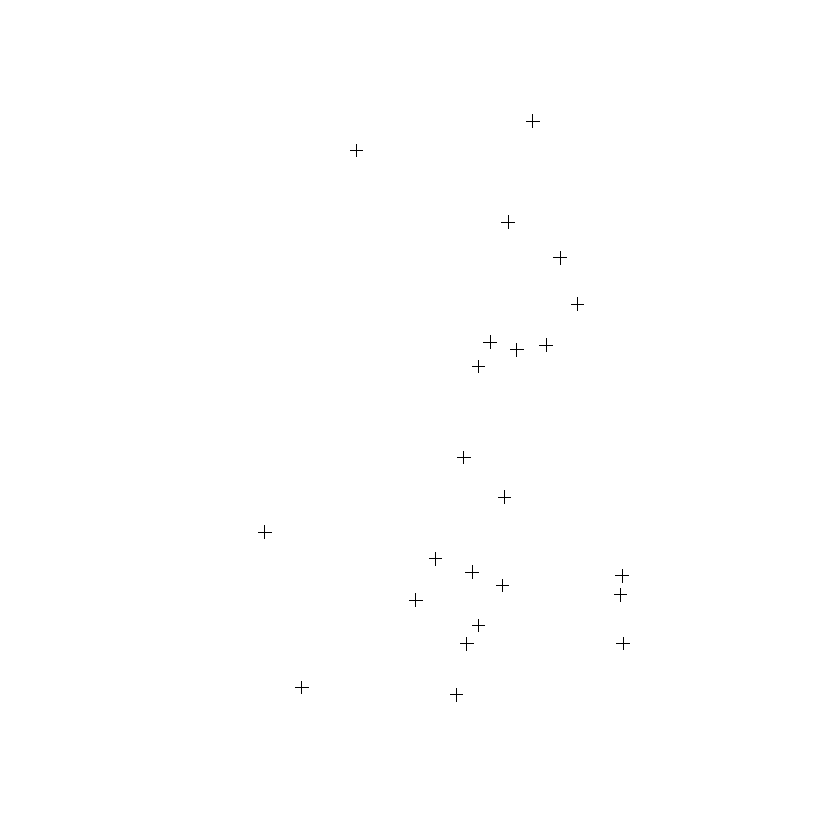

In [22]:
plot(sensoridSP.UTM,zcol="sensorid")

Create spatio-temporal using STFDF function from spacetime library
STFDF ข้อมูลจะแหว่งไม่ได้เลย

In [23]:
#stdata<-STFDF(sensoridSP,datetime$timepos,data.frame(PM2.5=as.vector(newhour$pm25)),delta(datetime$timepos))
stdata<-STFDF(sensoridSP.UTM,datetime$timepos,data.frame(PM2.5=as.vector(newdaily$pm25)),delta(datetime$timepos))

Then plot it

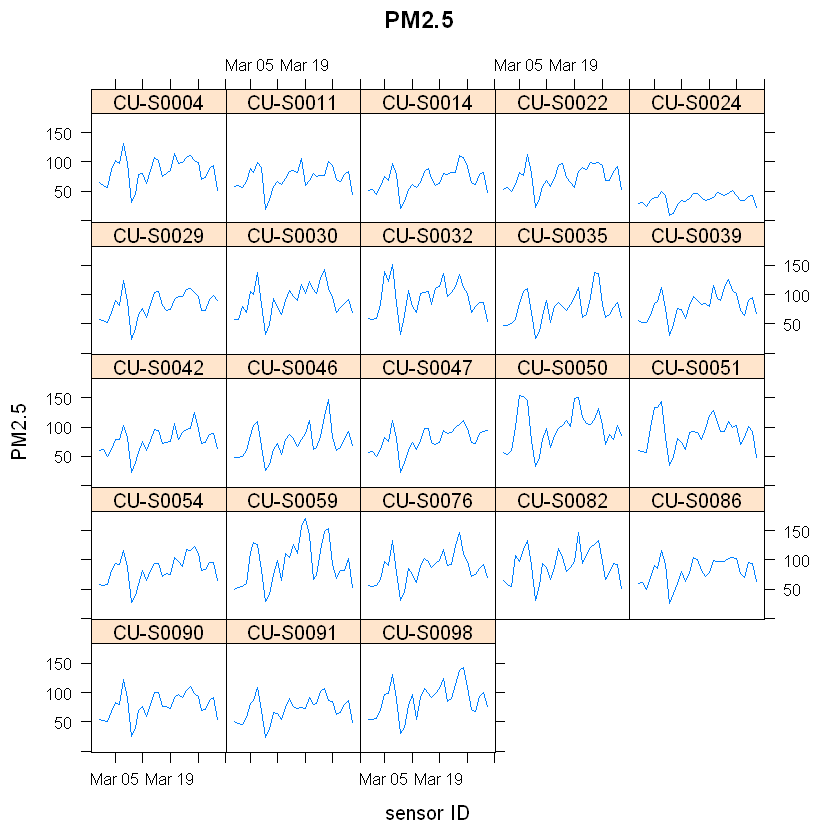

In [24]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")

scales <- list(x = list(rot = 45))
stplot(stdata,mode="tp",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

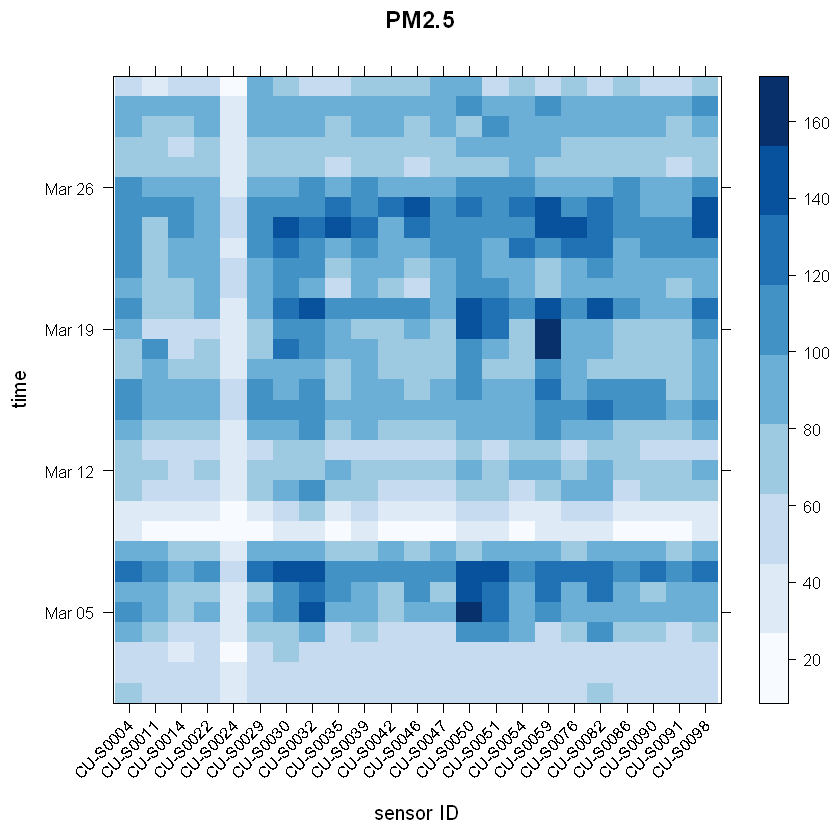

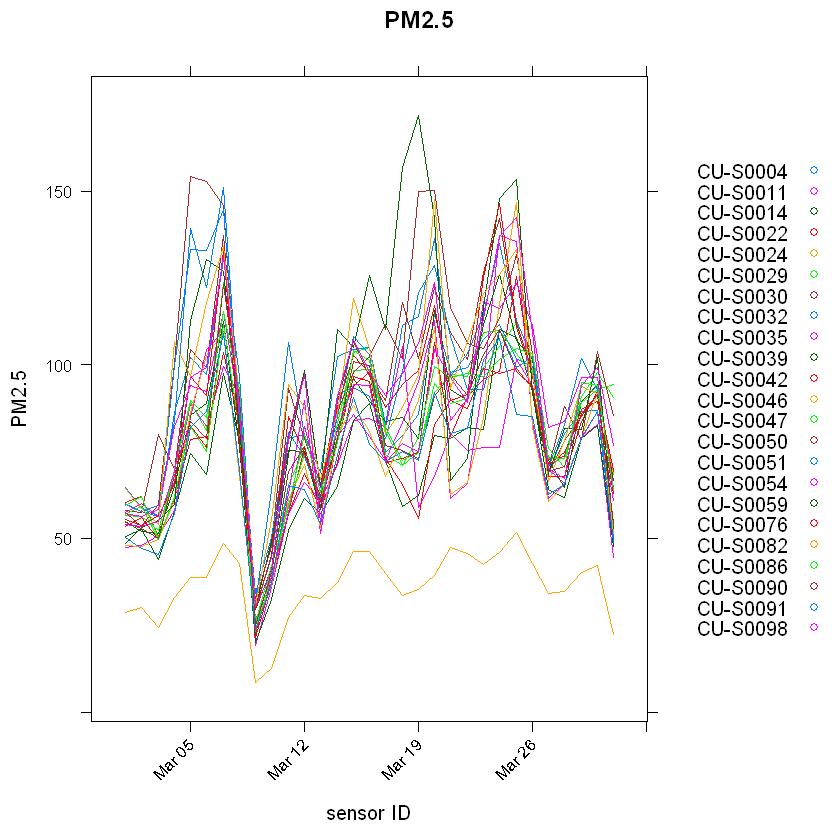

In [25]:
stplot(stdata,mode="xt",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)
stplot(stdata,mode="ts",scales=scales,xlab="sensor ID",col.regions = colorsetting)

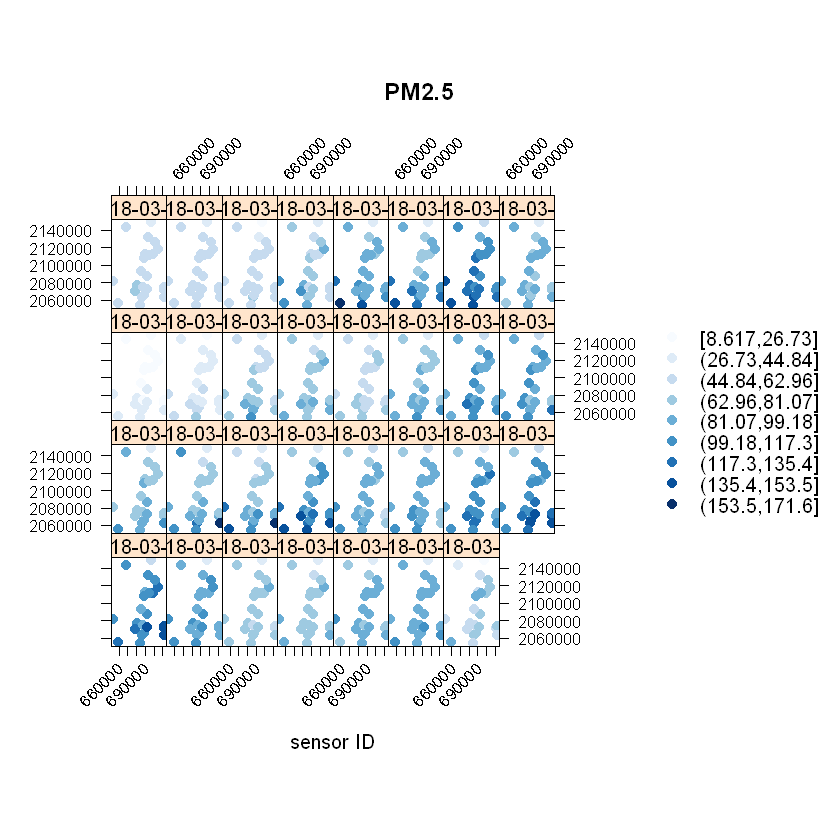

In [26]:
stplot(stdata,cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

In [27]:
summary(stdata)

Object of class STFDF
 with Dimensions (s, t, attr): (23, 31, 1)
[[Spatial:]]
Object of class SpatialPoints
Coordinates:
          min       max
lon  653277.9  712222.6
lat 2054252.4 2148610.9
Is projected: TRUE 
proj4string :
[+init=epsg:32647 +proj=utm +zone=47 +datum=WGS84 +units=m +no_defs
+ellps=WGS84 +towgs84=0,0,0]
Number of points: 23
[[Temporal:]]
     Index                       timeIndex   
 Min.   :2018-03-01 00:00:00   Min.   : 1.0  
 1st Qu.:2018-03-08 12:00:00   1st Qu.: 8.5  
 Median :2018-03-16 00:00:00   Median :16.0  
 Mean   :2018-03-16 00:00:00   Mean   :16.0  
 3rd Qu.:2018-03-23 12:00:00   3rd Qu.:23.5  
 Max.   :2018-03-31 00:00:00   Max.   :31.0  
[[Data attributes:]]
     PM2.5        
 Min.   :  8.617  
 1st Qu.: 61.451  
 Median : 81.066  
 Mean   : 80.659  
 3rd Qu.: 97.624  
 Max.   :171.639  

เลือกกลุ่มแรกๆมาจากที่แบ่ง k-mean ใน 2018 Analysis

In [28]:
rn <- c("CU-S0059","CU-S0064","CU-S0046","CU-S0081","CU-S0093","CU-S0072")

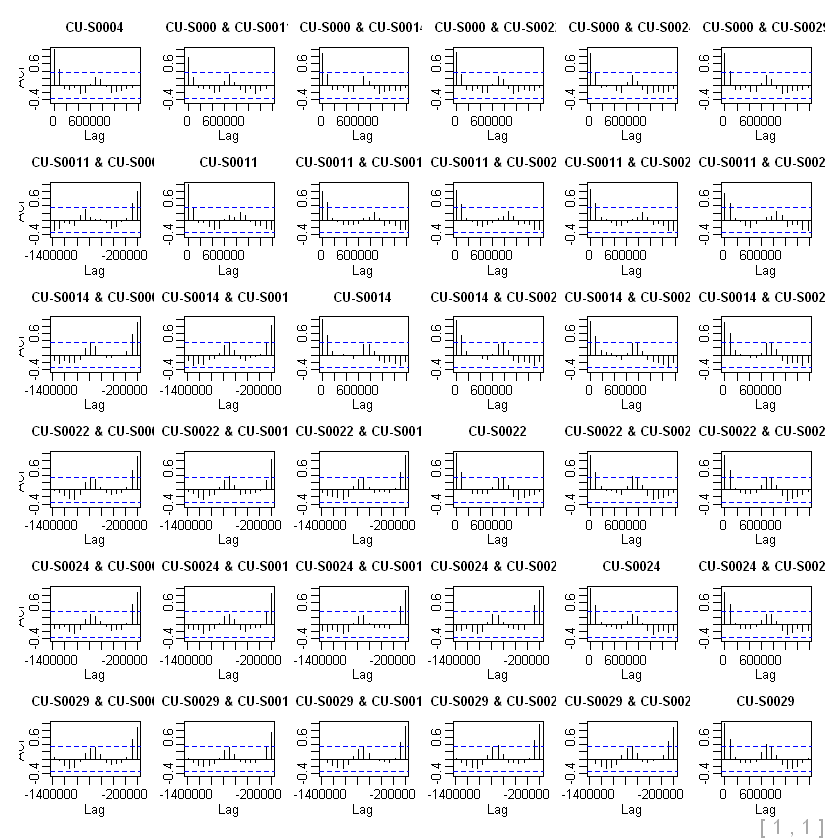

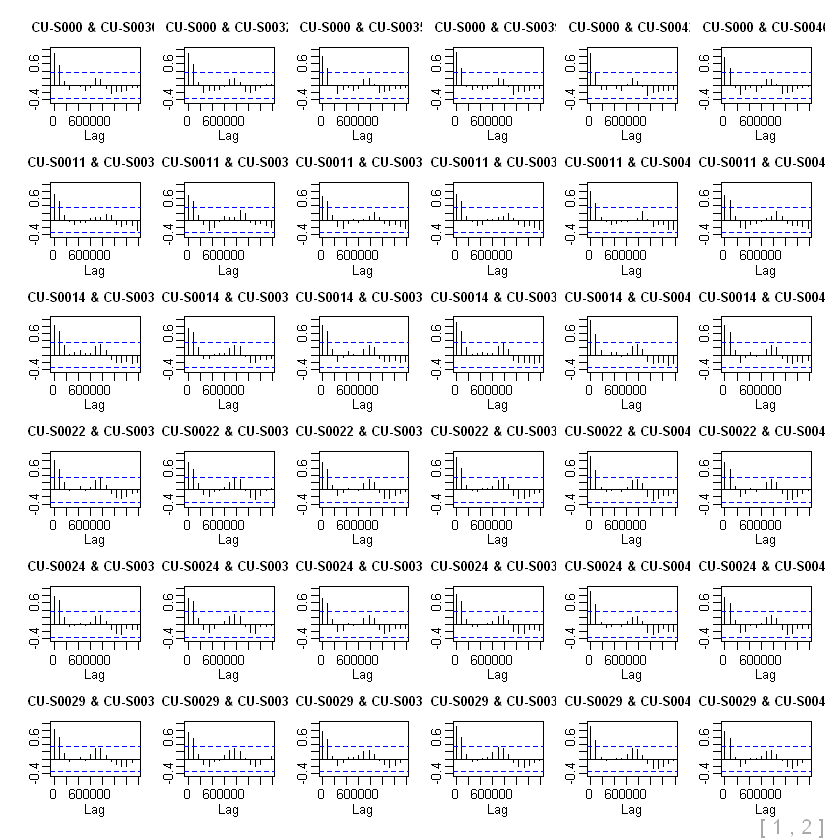

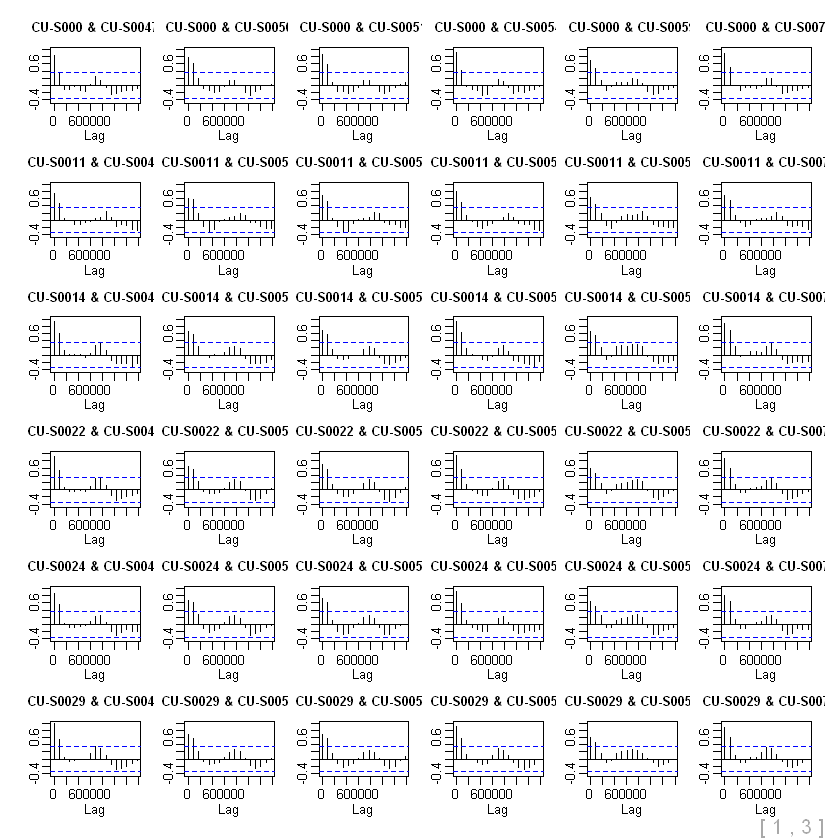

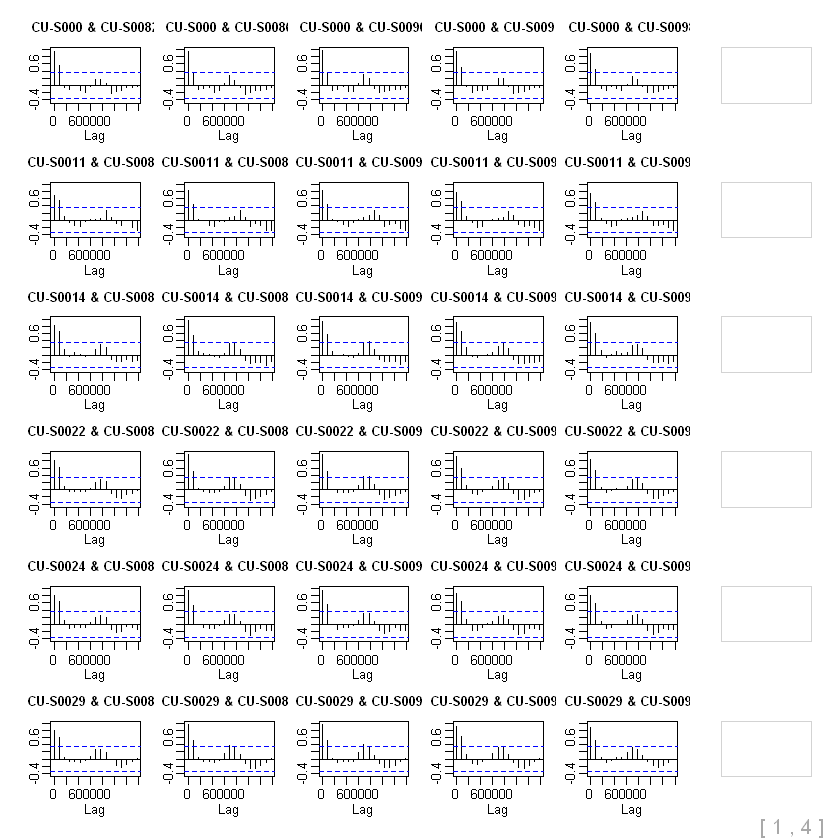

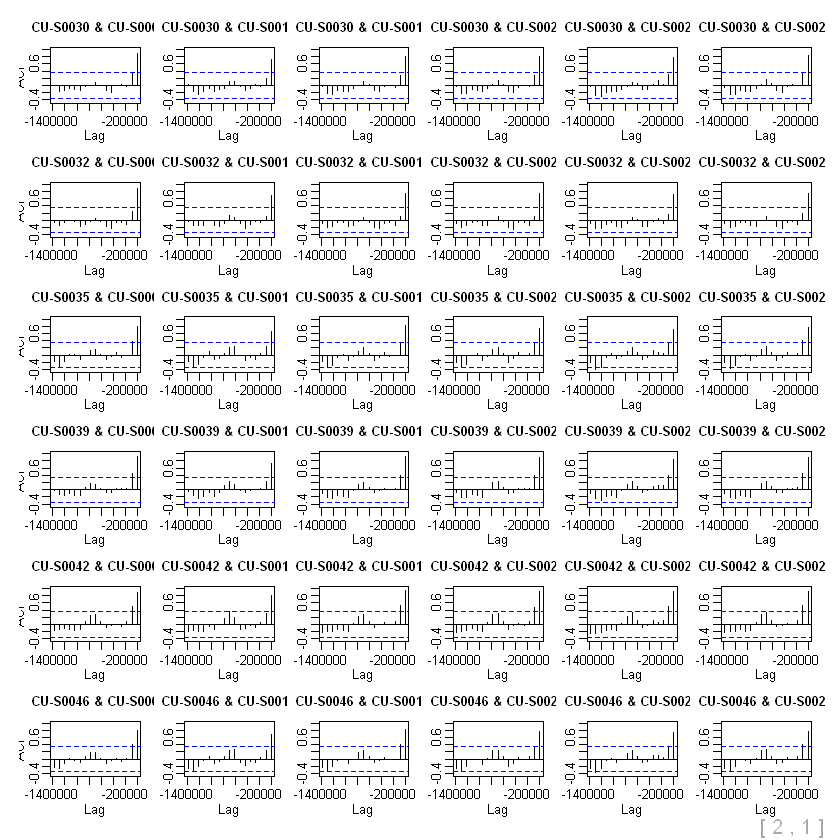

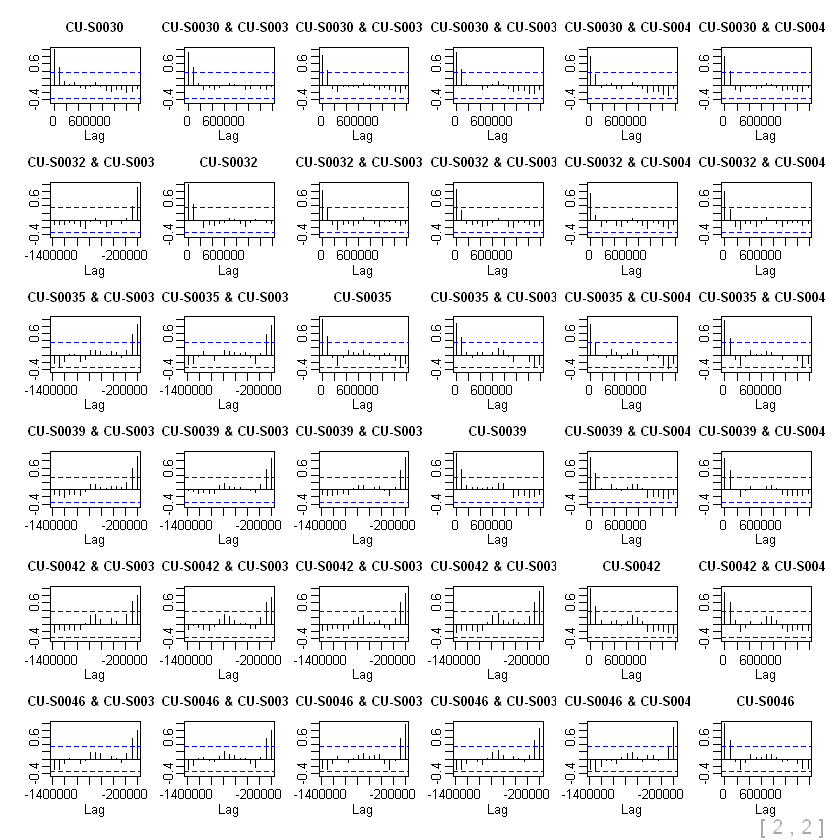

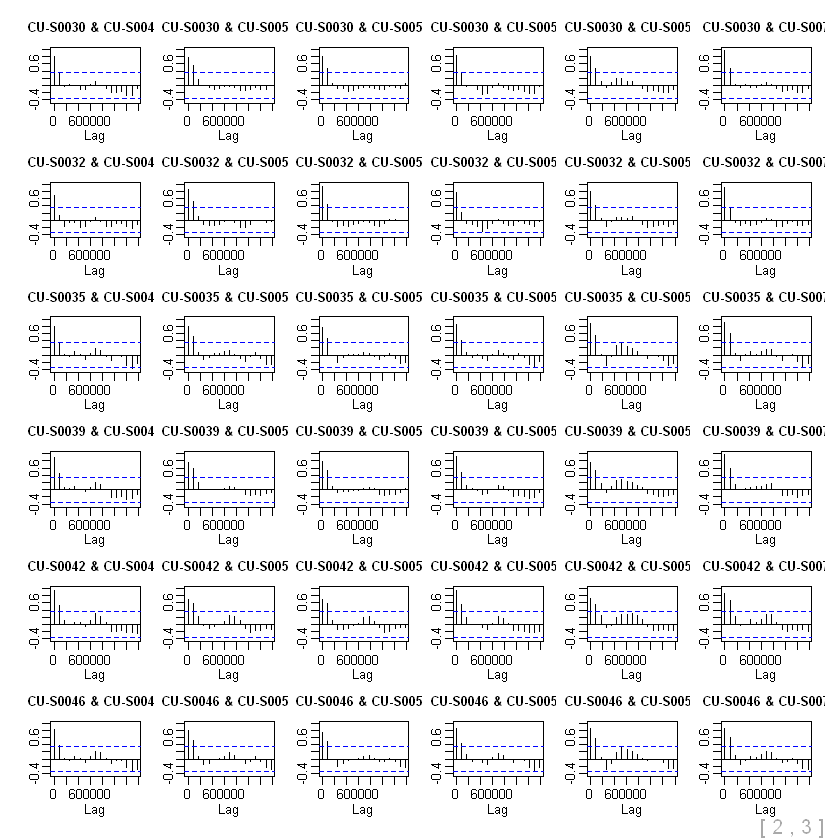

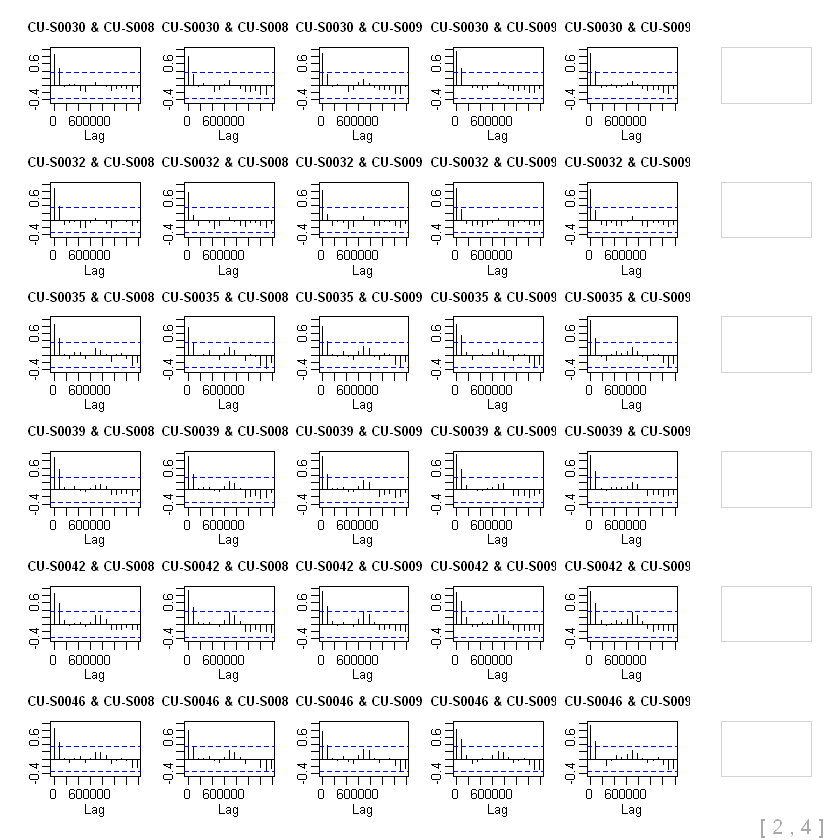

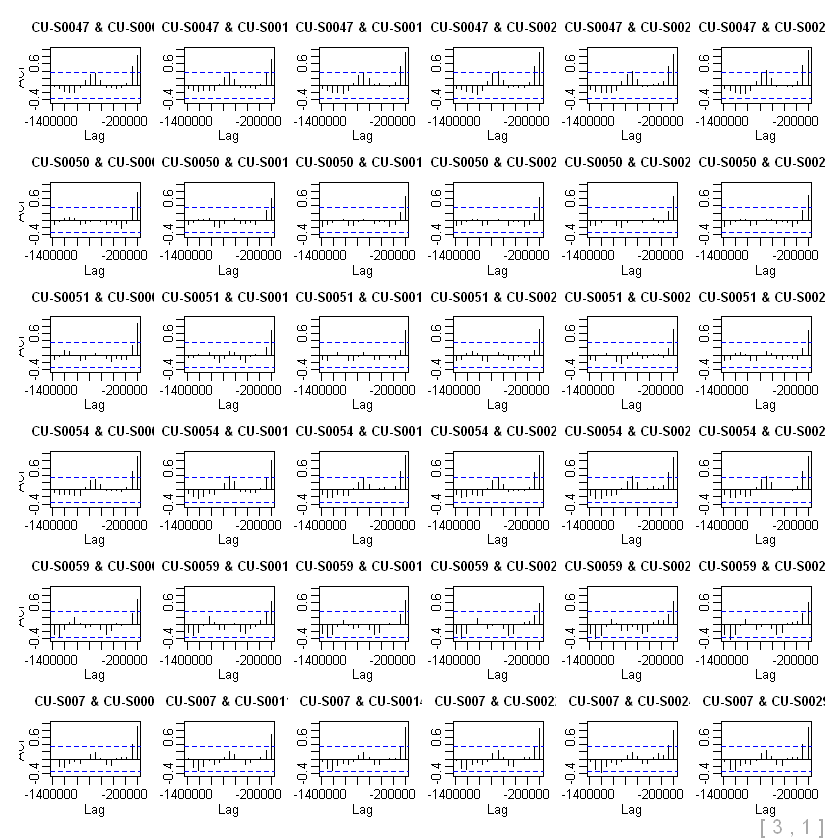

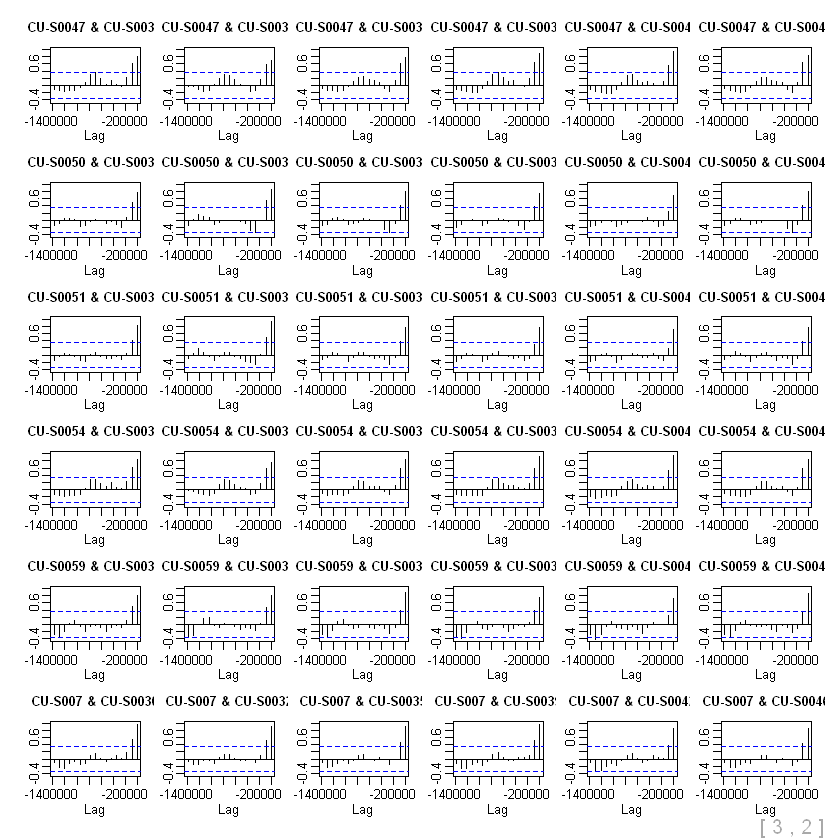

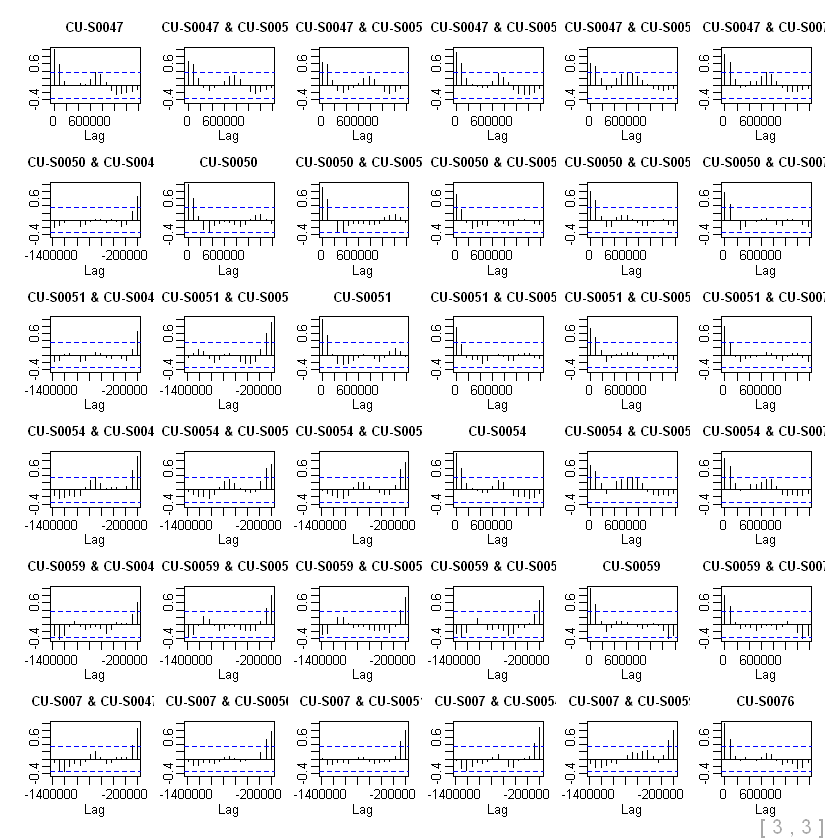

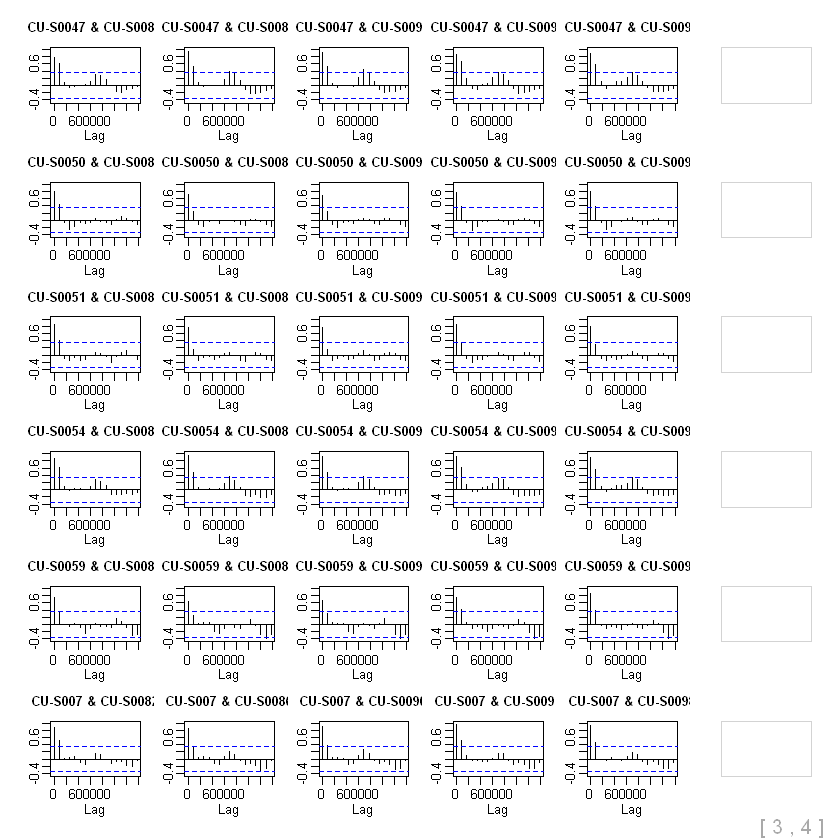

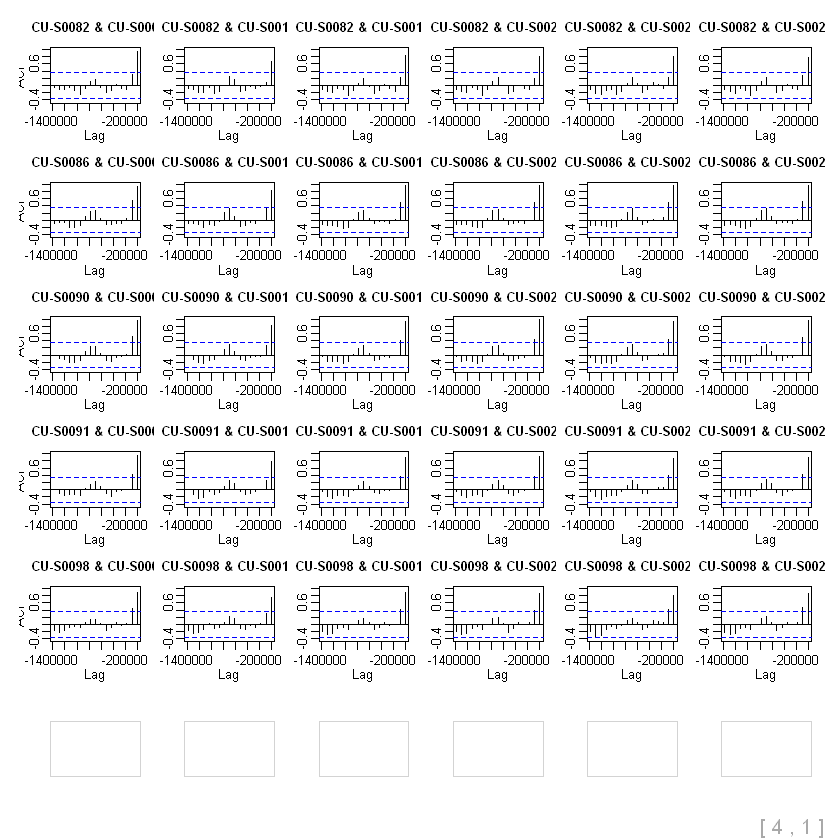

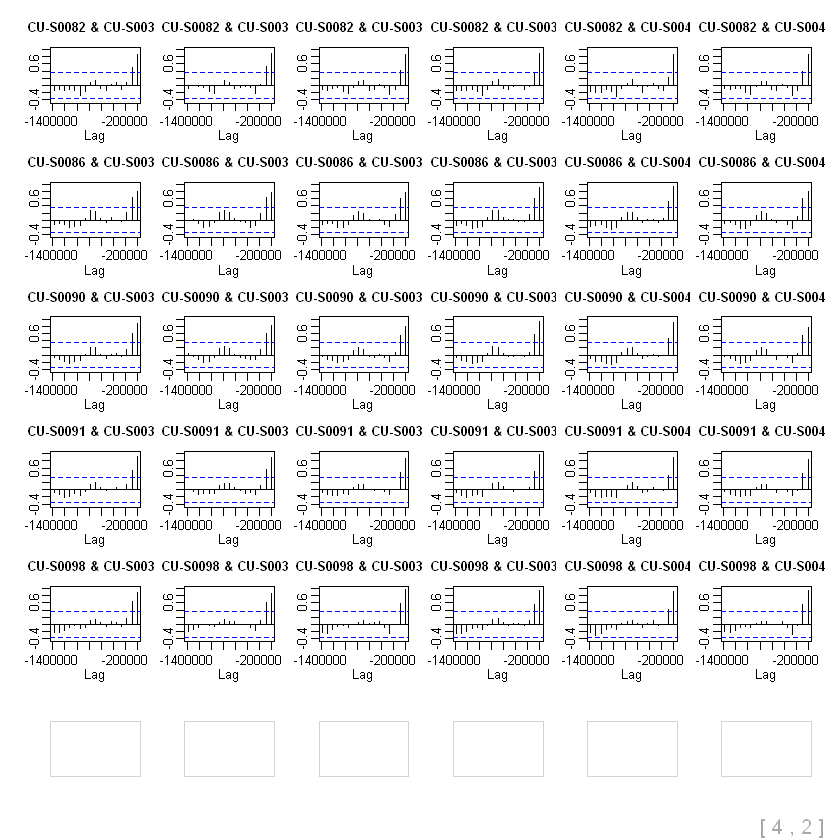

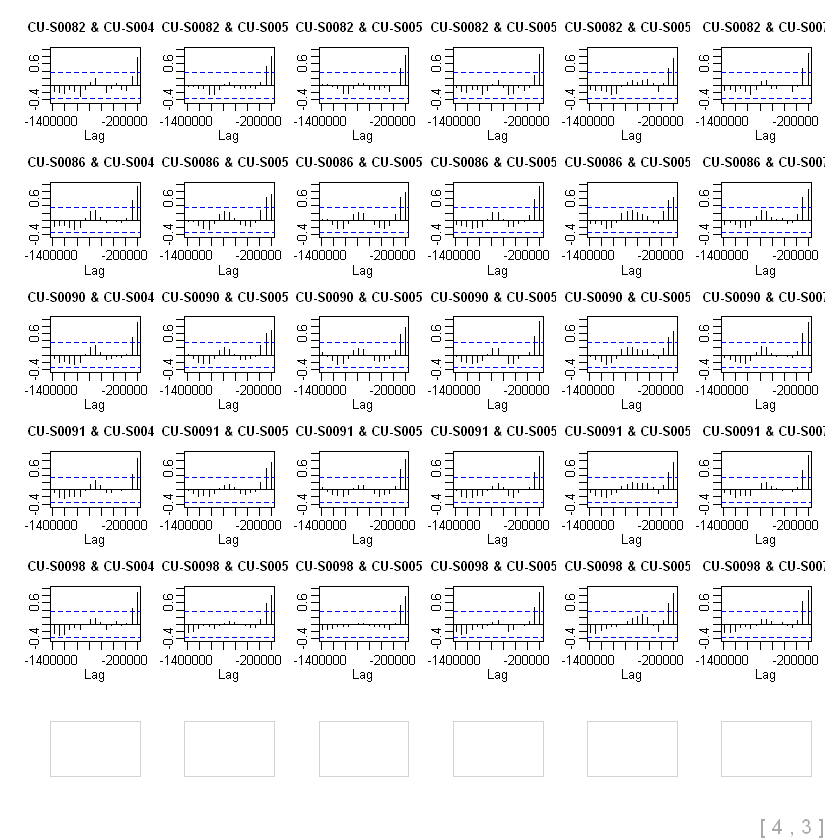

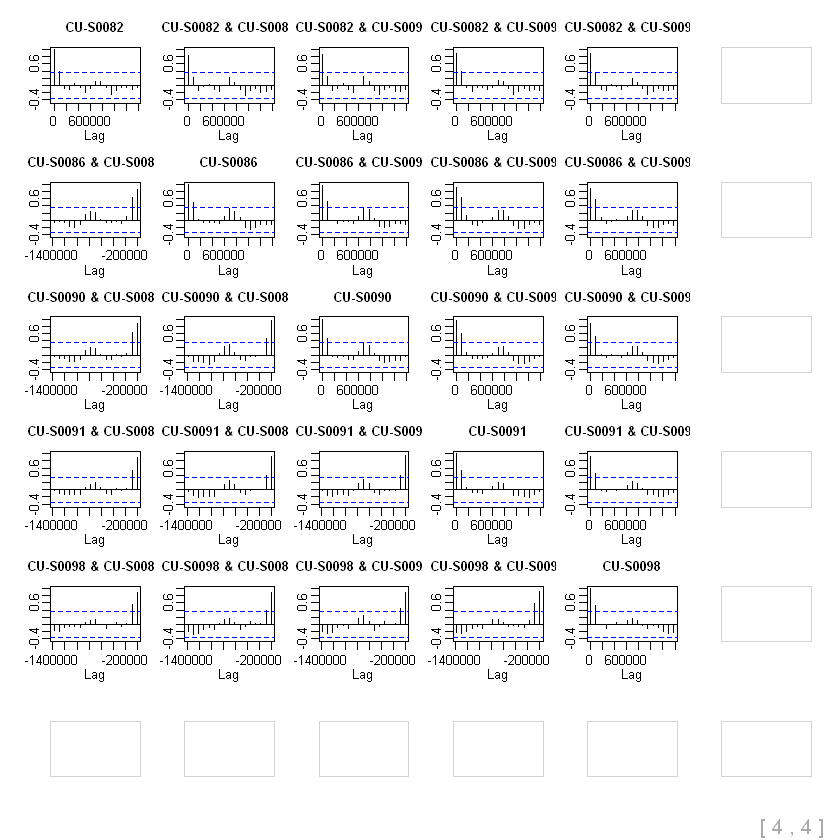

In [29]:
#acf(na.omit(as(stdata,"xts")),lag=16)

In [31]:
library(gstat)
vv = variogram(PM2.5~1, stdata, width=2500, tlags=0:6)

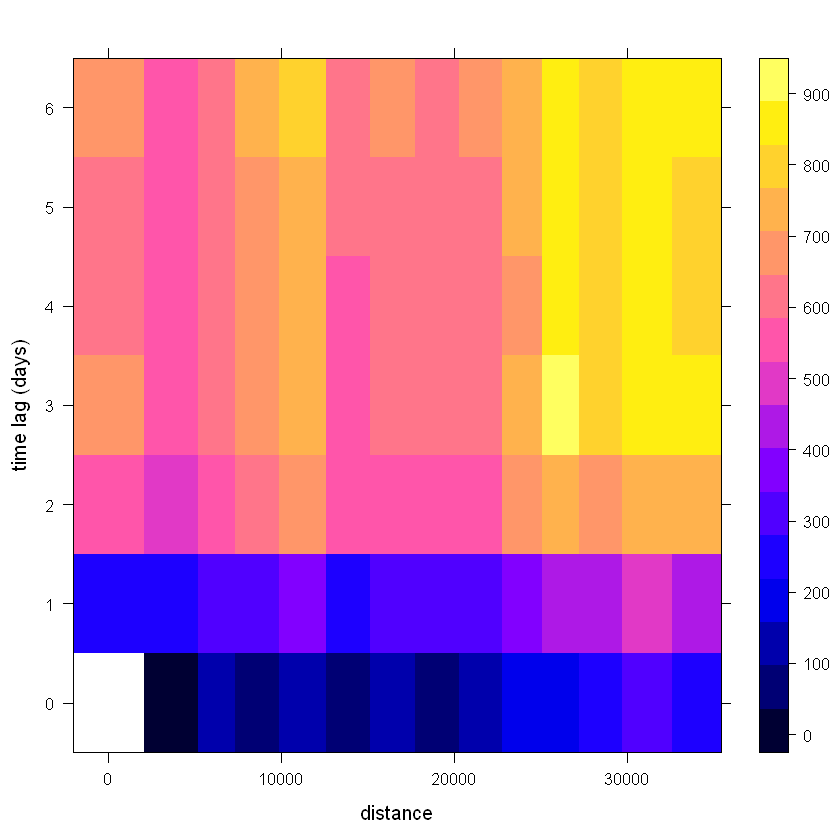

In [32]:
plot(vv)

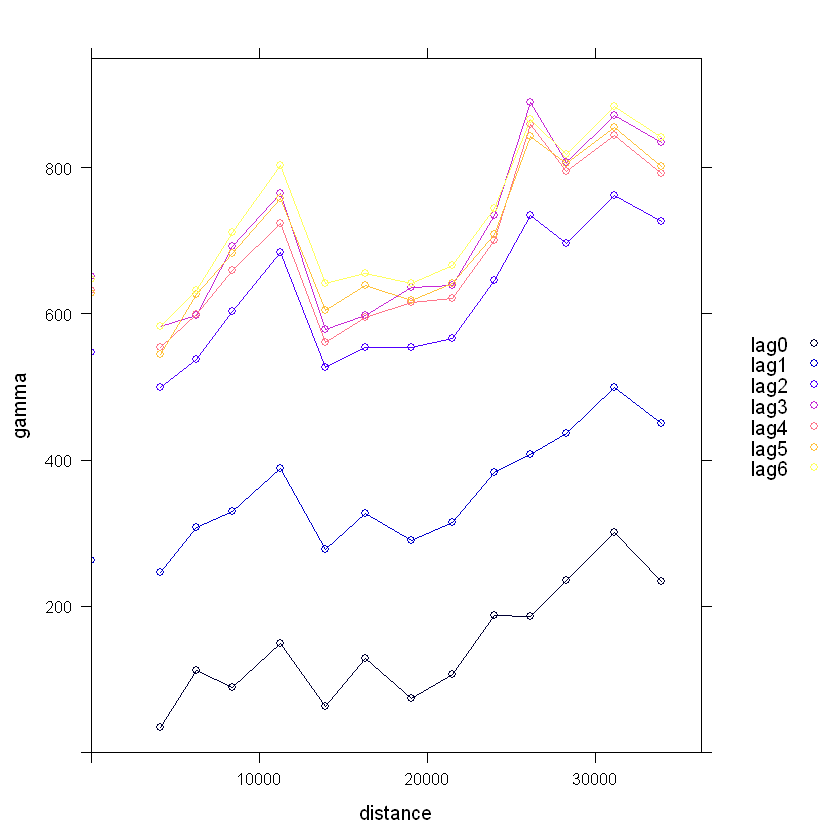

In [33]:
plot(vv, map = FALSE)

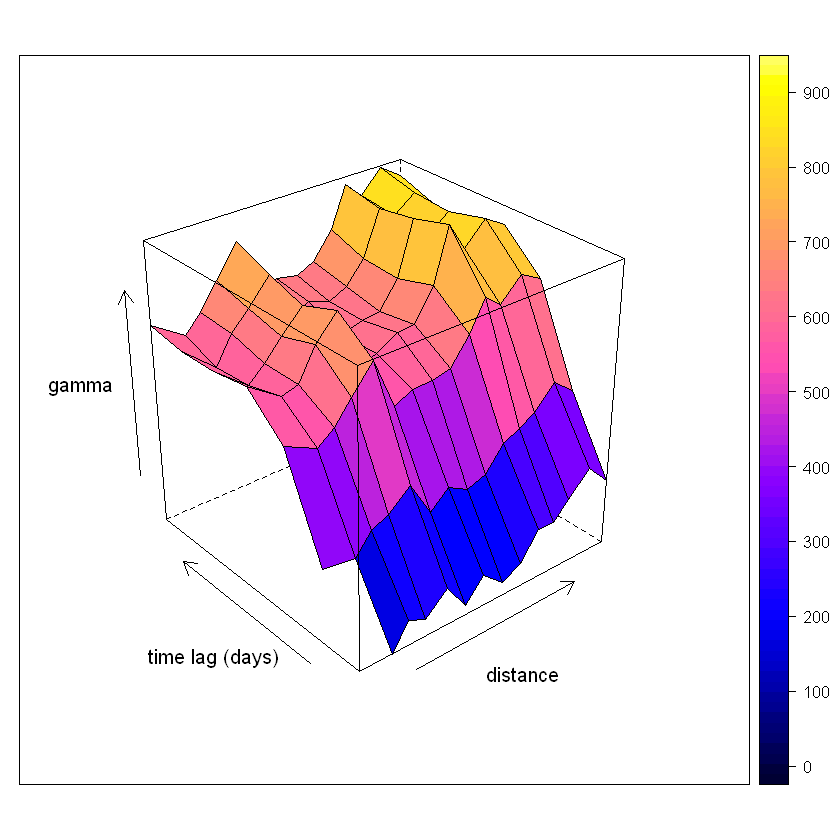

In [34]:
library(lattice)
plot(vv,all=T, wireframe=T)